# 0) 모듈 import


In [1]:
import warnings

warnings.filterwarnings(action='ignore')


In [2]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import numpy as np
import tensorflow as tf
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors


In [3]:
%%bash

pip install gensim==3.8.3
pip list | grep gensim

gensim                        3.8.3


## 1) 데이터 준비와 확인

In [4]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

IMDB 데이터셋은 텍스트를 가공하여 `imdb.data_loader()`메서드를 호출하면, 숫자 인덱스로 변환될 텍스트와 `word_to_index` 딕셔너리까지 제공한다. 

하지만, 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이뤄져있다. 이것을 읽어 `imdb.data_loader()`와 동일하게 동작하는 나만의`data_loader()`를 만들어보자.

`data_loader` 내에서는 다음을 수행해야 한다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴


In [5]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

In [6]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [7]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2

word_to_index.values()

dict_values([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word.keys() # 원래는 3부터

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [9]:
print(index_to_word[0])
print(index_to_word[7])
print(index_to_word[30])
print("------------")
print(word_to_index['가능'])
print(word_to_index['돈'])

<PAD>
고
음
------------
722
153


In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
# 텍스트가 decode되는지 보기

for i in range(5):
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1
재 
라벨:  0
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
라벨:  0
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다
라벨:  1


# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format( 100*np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
# padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.
1. RNN
2. CNN
3. ??


## 1. RNN

In [14]:
vocab_size = 10000 # 어휘 사전의 크기입니다
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_RNN.add(tf.keras.layers.Dense(16, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          200000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               283648    
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 487,777
Trainable params: 487,777
Non-trainable params: 0
_________________________________________________________________


## 2. 1-D CNN

In [15]:
model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          2256      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## 3. Pooling1D() layer 하나만 사용하기

In [16]:
model_Pool = tf.keras.Sequential()
model_Pool.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_Pool.add(tf.keras.layers.GlobalMaxPooling1D())
model_Pool.add(tf.keras.layers.Dense(8, activation='relu'))
model_Pool.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_Pool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 200,177
Trainable params: 200,177
Non-trainable params: 0
_________________________________________________________________


In [17]:
models = [model_RNN, model_CNN, model_Pool]

# 5) 모델 훈련 개시

In [18]:
# validation set 분리
devide = 30000

X_val = X_train[:devide]   
y_val = y_train[:devide]

# validation set을 제외한 나머지 116182건
partial_X_train = X_train[devide:]  
partial_y_train = y_train[devide:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [19]:
def train_model(model, epochs):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=2)
    return history

In [20]:
historys = []
epochs = 10

In [21]:
for model in models:
    print(model.name)
    historys.append( train_model(model,epochs) )
    print("============finished=============")

sequential
Epoch 1/10
227/227 - 8s - loss: 0.4716 - accuracy: 0.7724 - val_loss: 0.3555 - val_accuracy: 0.8467
Epoch 2/10
227/227 - 4s - loss: 0.3355 - accuracy: 0.8582 - val_loss: 0.3426 - val_accuracy: 0.8527
Epoch 3/10
227/227 - 4s - loss: 0.3141 - accuracy: 0.8690 - val_loss: 0.3407 - val_accuracy: 0.8519
Epoch 4/10
227/227 - 4s - loss: 0.2965 - accuracy: 0.8770 - val_loss: 0.3362 - val_accuracy: 0.8544
Epoch 5/10
227/227 - 4s - loss: 0.2760 - accuracy: 0.8861 - val_loss: 0.3395 - val_accuracy: 0.8555
Epoch 6/10
227/227 - 4s - loss: 0.2530 - accuracy: 0.8966 - val_loss: 0.3350 - val_accuracy: 0.8569
Epoch 7/10
227/227 - 4s - loss: 0.2328 - accuracy: 0.9059 - val_loss: 0.3472 - val_accuracy: 0.8544
Epoch 8/10
227/227 - 4s - loss: 0.2144 - accuracy: 0.9137 - val_loss: 0.3820 - val_accuracy: 0.8538
Epoch 9/10
227/227 - 4s - loss: 0.1995 - accuracy: 0.9205 - val_loss: 0.3888 - val_accuracy: 0.8515
Epoch 10/10
227/227 - 4s - loss: 0.1838 - accuracy: 0.9274 - val_loss: 0.4169 - val_accur

In [22]:
# 평가
results = []

for model in models:
    results.append(model.evaluate(X_test, y_test, verbose=2))
    print("=======evaluate finished=======") 
    
print(results)    

1537/1537 - 3s - loss: 0.4234 - accuracy: 0.8464
=======evaluate finished=======
1537/1537 - 3s - loss: 0.5982 - accuracy: 0.8308
=======evaluate finished=======
1537/1537 - 2s - loss: 0.4053 - accuracy: 0.8390
=======evaluate finished=======
[[0.42336294054985046, 0.8463901281356812], [0.5982340574264526, 0.8308073878288269], [0.40528422594070435, 0.83904629945755]]


# 6) Loss, Accuracy 그래프 시각화

In [23]:
import matplotlib.pyplot as plt

def visualize_history(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    ## Loss
    
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, 'r', label='Training loss')

    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracyt
    plt.subplot(1,2,2)
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

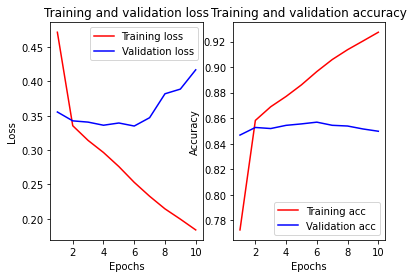

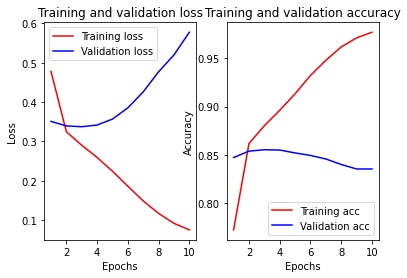

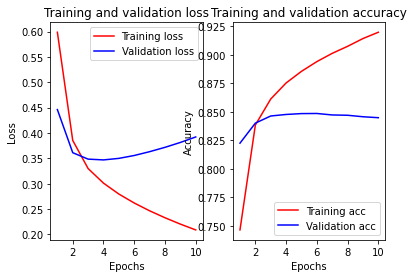

In [24]:
for i, history in enumerate(historys):
    visualize_history(history)

# 7) 학습된 Embedding 레이어 분석

In [25]:
def get_weights(model):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    return weights.shape    # shape: (vocab_size, embedding_dim)

In [26]:
for i, model in enumerate(models):
    print(get_weights(model))

(10000, 20)
(10000, 20)
(10000, 20)


In [27]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
def save_weights(index, model):
    global word2vec_file_path
    word2vec_file_path = os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_{index}.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  
        # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
            
    f.close()
    print("saved")

In [28]:
for idx, model in enumerate(models):
    save_weights(idx, model)

saved
saved
saved


In [29]:
# word vector로 사용하기
word_vectors_list = []

for index in range(3):
    word_vectors_list.append(Word2VecKeyedVectors.load_word2vec_format(os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_{index}.txt', binary=False))

for i, word_vectors in enumerate(word_vectors_list):
    word = "인생"
    vector = word_vectors[word]
    print("===========================")
    for j in word_vectors.similar_by_word(word):
        print(j)

('음악', 0.9368330240249634)
('넘어서', 0.9160672426223755)
('잡힌', 0.9133095741271973)
('늠', 0.9127670526504517)
('네티즌', 0.9104046821594238)
('넘겼', 0.9026907682418823)
('원하', 0.9011950492858887)
('사고', 0.8991989493370056)
('근대', 0.8985429406166077)
('호불호', 0.8980161547660828)
('고마워', 0.758621335029602)
('한수', 0.722429633140564)
('노예', 0.6816998720169067)
('갑', 0.6811471581459045)
('치열', 0.6802113056182861)
('ㅠㅠ진짜', 0.6792330741882324)
('윤아', 0.6787010431289673)
('누군가', 0.6726905703544617)
('발매', 0.6678926944732666)
('안타깝', 0.6629780530929565)
('로썬', 0.713898241519928)
('될까요', 0.7055188417434692)
('탄압', 0.6887662410736084)
('터트리', 0.6850383281707764)
('풀어낼', 0.6737577319145203)
('이라고', 0.673680305480957)
('레이첼', 0.6675298810005188)
('죽이', 0.663711667060852)
('카', 0.6606565713882446)
('알려준', 0.655177116394043)


# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

위 링크에서 적절한 ko.bin을 찾아 이용하세요. 그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.


In [30]:
import gensim
import gensim.models
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors


In [31]:
# word2vec 가져오기
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec["돈"]
vector    

array([ 0.1429886 , -0.51569444, -0.17905036,  0.6990943 , -1.2470347 ,
       -0.4675792 , -0.5140027 ,  0.3851181 ,  1.6413882 ,  0.05373307,
        3.4940295 ,  1.0863705 ,  0.213987  ,  0.50876665,  0.0595099 ,
       -0.635576  ,  0.80967236, -0.30598873, -1.1070285 ,  0.00687107,
        0.13352521, -1.7703569 , -1.9542334 , -0.24859954,  0.7568666 ,
       -1.5070641 ,  1.5828912 , -0.9788056 , -0.30619308,  1.6553999 ,
        0.9743179 , -0.88774705, -0.5740832 , -2.4162974 , -0.25419185,
        1.2994269 , -0.866042  ,  0.73982203, -0.30623046,  0.85625994,
       -0.71490186, -0.6105656 ,  0.6202518 , -2.2734773 ,  0.07169852,
       -1.760702  ,  0.25796548, -1.2585342 , -0.5893524 ,  0.06625422,
       -0.98701894, -0.12881544,  0.64208347, -0.26338592,  0.23140413,
        1.5266788 ,  1.7522976 ,  1.5980453 ,  0.2286358 , -0.12704618,
        1.2352053 ,  1.2871912 ,  0.88741845, -0.6980704 ,  1.4871577 ,
       -0.49122274, -0.6351779 ,  0.3178652 ,  1.598648  ,  0.05

In [33]:
word2vec.similar_by_word("돈")

[('현상금', 0.5432437062263489),
 ('몸값', 0.5052939653396606),
 ('거액', 0.49363428354263306),
 ('지갑', 0.4833971858024597),
 ('냥', 0.4811705946922302),
 ('돈은', 0.4542396664619446),
 ('선물', 0.4430036246776581),
 ('재물', 0.4388188421726227),
 ('봉록', 0.4359300136566162),
 ('금품', 0.43222159147262573)]

In [36]:
# 임베딩 레이어를 word2vec의 것으로 교체 후 학습

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [109]:
from tensorflow.keras.initializers import Constant


vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               467968    
_________________________________________________________________
dense_40 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 2,484,481
Trainable params: 2,484,481
Non-trainable params: 0
_________________________________________________________________


In [110]:
# 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/5
114/114 - 8s - loss: 0.4301 - accuracy: 0.7963 - val_loss: 0.3438 - val_accuracy: 0.8512
Epoch 2/5
114/114 - 7s - loss: 0.3217 - accuracy: 0.8622 - val_loss: 0.3361 - val_accuracy: 0.8539
Epoch 3/5
114/114 - 7s - loss: 0.2904 - accuracy: 0.8771 - val_loss: 0.3286 - val_accuracy: 0.8576
Epoch 4/5
114/114 - 7s - loss: 0.2579 - accuracy: 0.8914 - val_loss: 0.3447 - val_accuracy: 0.8579
Epoch 5/5
114/114 - 7s - loss: 0.2315 - accuracy: 0.9037 - val_loss: 0.3490 - val_accuracy: 0.8581


In [111]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3564 - accuracy: 0.8541
[0.35640814900398254, 0.8540594577789307]


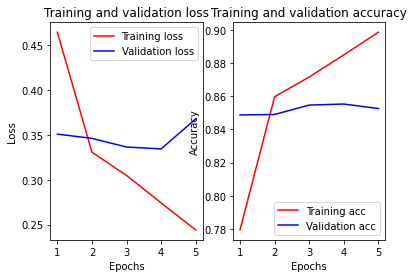

In [108]:
visualize_history(history)

# 회고

1. 이번 프로젝트에서 어려웠던 점   
- 내용을 이해하는 게 시간이 오래 걸렸다. 85% 이상을 만드는 데 많은 시간이 걸렸다.

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.   
- gensim을 불러와서 돌리기 위해서,개념을 더욱 정확히 이해해야 했었다.
- 미처 몰랐는데, 알게돼서 신기했던 점은 RNN이 아니더라도 자연어를 학습할 수 있다는 점이 신기했다.
- 이것저것 구글링을 하면서, gensim을 사용하긴 했지만, 아직 정확히 어떻게 돌리는지는 남에게 설명할 수 있을만큼 이해하진 못한 것 같다.

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들   
- 최적의 하이퍼 파라미터를 찾기 위해 많은 노력을 하였다. 배치 사이즈와 LSTM layer도 바꾸고, Dense layer도 추가해보았다. 하지만 dense layer를 추가하는 게 큰 변화를 가져오지는 못했다.